<a href="https://colab.research.google.com/github/33GuessSo88/Brokerage_Agent_Analysis/blob/main/Brokerage_and_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ============================================
# SECTION 1: INITIAL SETUP AND IMPORTS
# ============================================
# This section imports required libraries and sets up connection to Google Drive
# Libraries used:
# - pandas: for data manipulation and analysis
# - os: for file and directory operations
# - google.colab: for Google Drive integration

import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd  # Make sure this is also imported

# Mount Google Drive to access files
# This step is required only once per session
drive.mount('/content/drive')

# ============================================
# SECTION 2: CONFIGURATION
# ============================================
# Define the directory path where CSV files are stored
# This path points to the specific folder in Google Drive containing MLS data

directory_path = '/content/drive/My Drive/Realtor/Data Project/2024 Brokerage and Agent Sales/Raw CSV files from MLS'

# Initialize tracking variables
# These variables help monitor the processing progress
all_dfs = []              # List to store all processed DataFrames
csv_files_processed = 0   # Counter for successfully processed CSV files
non_csv_files_skipped = 0 # Counter for non-CSV files encountered

# ============================================
# SECTION 3: FILE PROCESSING
# ============================================
# This section loops through all files in the directory and processes CSV files

# First, verify the directory exists
if not os.path.exists(directory_path):
    raise FileNotFoundError(f"Directory not found: {directory_path}")

# Process each file in the directory
for filename in os.listdir(directory_path):
    # Check if current file is a CSV
    if filename.endswith(".csv"):
        # Create complete file path by joining directory path and filename
        file_path = os.path.join(directory_path, filename)

        try:
            # Attempt to read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Verify the DataFrame is not empty
            if df.empty:
                print(f"Warning: {filename} is empty - skipping file")
                continue

            # Verify required columns exist (we'll need these later)
            required_columns = ['Buyer Office Name', 'List Office Name']
            missing_columns = [col for col in required_columns if col not in df.columns]

            if missing_columns:
                print(f"Warning: {filename} is missing required columns {missing_columns} - skipping file")
                continue

            # Remove any duplicate rows within the current file
            rows_before = len(df)
            df.drop_duplicates(inplace=True)
            rows_removed = rows_before - len(df)

            if rows_removed > 0:
                print(f"Removed {rows_removed} duplicate rows from {filename}")

            # Add processed DataFrame to our collection
            all_dfs.append(df)
            csv_files_processed += 1
            print(f"Successfully loaded: {filename}")

        except pd.errors.EmptyDataError:
            # Handle empty CSV files
            print(f"Warning: {filename} is empty.")
        except pd.errors.ParserError:
            # Handle CSV files with incorrect format
            print(f"Error: Could not parse {filename}. Check the file format.")
        except Exception as e:
            # Handle any other unexpected errors
            print(f"Error loading {filename}: {e}")
    else:
        # Track non-CSV files that are skipped
        non_csv_files_skipped += 1
        print(f"Skipping non-CSV file: {filename}")

# ============================================
# SECTION 4: PROCESSING SUMMARY
# ============================================
# Print summary of file processing results
print(f"\nProcessed {csv_files_processed} CSV files.")
print(f"Skipped {non_csv_files_skipped} non-CSV files.")

# ============================================
# SECTION 5: DATA MERGING AND INITIAL ANALYSIS
# ============================================
# This section combines all processed DataFrames and creates our main DataFrame

if all_dfs:
    # Make a copy of our list of DataFrames before merging
    # This gives us a backup in case we need the original data
    all_dfs_original = all_dfs.copy()

    # Combine all DataFrames into a single DataFrame
    print("\nMerging all DataFrames...")
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Save the original column names for reference
    original_columns = merged_df.columns.tolist()
    print("\nOriginal Columns:")
    for col in original_columns:
        print(f"- {col}")

    # Display initial data info
    print("\nInitial Data Summary:")
    print(f"Total number of rows: {len(merged_df):,}")
    print(f"Total number of columns: {len(merged_df.columns):,}")

    # Check for duplicates in merged data
    duplicates = merged_df.duplicated().sum()
    print(f"\nFound {duplicates:,} duplicate rows in merged data")

    if duplicates > 0:
        # Remove duplicates and track the change
        rows_before = len(merged_df)
        merged_df.drop_duplicates(inplace=True)
        rows_after = len(merged_df)
        print(f"Removed {rows_before - rows_after:,} duplicate rows")

    # Store our cleaned DataFrame for use in next code block
    # We keep the original column names at this stage
    initial_df = merged_df.copy()

    print("\nData preparation complete. Ready for column cleaning in next block.")
    print("\nAvailable DataFrames for next block:")
    print("- initial_df: Main DataFrame with original column names")
    print("- all_dfs_original: List of original DataFrames (if needed)")

else:
    print("No CSV files were successfully loaded.")
    print("Please check your directory path and ensure CSV files are present.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded: Brokerage and Agent Export.csv
Successfully loaded: Brokerage and Agent Export (1).csv
Successfully loaded: Brokerage and Agent Export (2).csv
Successfully loaded: Brokerage and Agent Export (3).csv
Successfully loaded: Brokerage and Agent Export (4).csv
Successfully loaded: Brokerage and Agent Export (5).csv

Processed 6 CSV files.
Skipped 0 non-CSV files.

Merging all DataFrames...

Original Columns:
- #
- MLS® #
- St
- City
- Buyer Office Name
- List Office Name
- Current Price
- Close Price
- Co Buyer Agent Full Name
- Buyer Agent Full Name
- List Agent Full Name
- Co List Agent Full Name

Initial Data Summary:
Total number of rows: 27,564
Total number of columns: 12

Found 345 duplicate rows in merged data
Removed 345 duplicate rows

Data preparation complete. Ready for column cleaning in next block.

Available DataFrames for next bl

In [6]:
# ============================================
# SECTION: COLUMN CLEANUP AND STANDARDIZATION
# ============================================
# This section processes our initial DataFrame to clean and standardize column names.
# We'll create a new DataFrame for our cleaned data to preserve the original.
# The process includes:
# 1. Creating a safe copy of our data
# 2. Removing unnecessary columns
# 3. Cleaning special characters and symbols
# 4. Standardizing format (lowercase, underscores instead of spaces)
# 5. Special handling for specific columns (mls, st)
# 6. Printing before and after column names for verification

# First, verify we have our initial DataFrame
if 'initial_df' not in locals():
    print("Error: initial_df not found. Please run the previous code block first.")
else:
    try:
        # ----------------------------------------
        # Create a safe copy of our data
        # ----------------------------------------
        print("Creating working copy of DataFrame...")
        working_df = initial_df.copy()

        # ----------------------------------------
        # Display original column names for reference
        # ----------------------------------------
        print("\nOriginal Column Names:")
        for col in working_df.columns:
            print(f"- {col}")

        # ----------------------------------------
        # Remove unnecessary columns
        # ----------------------------------------
        # Create a copy of columns to track changes
        original_columns = working_df.columns.tolist()

        # Check and remove '#' column if it exists
        if '#' in working_df.columns:
            working_df = working_df.drop('#', axis=1)
            print("\nRemoved '#' column successfully")
        else:
            print("\nNote: Column '#' not found in the DataFrame")

        # Remove 'St' column if it exists (case-insensitive check)
        st_cols = [col for col in working_df.columns if col.lower() == 'st']
        if st_cols:
            working_df = working_df.drop(st_cols[0], axis=1)
            print(f"Removed '{st_cols[0]}' column successfully")
        else:
            print("Note: Column 'St' not found in the DataFrame")

        # ----------------------------------------
        # Clean and standardize column names
        # ----------------------------------------
        # Create a copy of columns for cleaning
        new_columns = working_df.columns.tolist()

        print("\nCleaning column names step by step...")

        # Step 1: Remove leading and trailing spaces
        new_columns = [col.strip() for col in new_columns]
        print("✓ Removed leading/trailing spaces")

        # Step 2: Remove common unnecessary words
        new_columns = [col.replace(' Name', '').replace(' Full', '') for col in new_columns]
        print("✓ Removed unnecessary words (Name, Full)")

        # Step 3: Remove copyright symbols and handle MLS specially
        new_columns = [col.replace('®', '') for col in new_columns]
        new_columns = ['MLS' if col == 'MLS® #' else col for col in new_columns]
        print("✓ Removed copyright symbols and standardized MLS column")

        # Step 4: Remove special characters (except spaces)
        new_columns = [col.replace('#', '').replace('(', '').replace(')', '') for col in new_columns]
        print("✓ Removed special characters")

        # Step 5: Convert to lowercase
        new_columns = [col.lower() for col in new_columns]
        print("✓ Converted to lowercase")

        # Step 6: Replace spaces with underscores
        new_columns = [col.replace(' ', '_') for col in new_columns]
        print("✓ Replaced spaces with underscores")

        # Step 7: Special handling for 'mls' column
        new_columns = [col.replace('mls_', 'mls') for col in new_columns]
        print("✓ Applied special handling for MLS column")

        # ----------------------------------------
        # Apply cleaned column names and verify
        # ----------------------------------------
        # Verify we haven't created any duplicate column names
        if len(set(new_columns)) != len(new_columns):
            print("\nWarning: Cleaning process created duplicate column names!")
            # Find duplicates
            from collections import Counter
            duplicates = [item for item, count in Counter(new_columns).items() if count > 1]
            print(f"Duplicate columns: {duplicates}")
            raise ValueError("Cannot proceed with duplicate column names")

        # Apply new column names
        working_df.columns = new_columns

        # ----------------------------------------
        # Display results
        # ----------------------------------------
        print("\nColumn Cleaning Summary:")
        print(f"Original number of columns: {len(original_columns)}")
        print(f"Final number of columns: {len(new_columns)}")

        print("\nFinal Column Names:")
        for col in working_df.columns:
            print(f"- {col}")

        # ----------------------------------------
        # Store cleaned DataFrame
        # ----------------------------------------
        # Save our cleaned DataFrame for the next code block
        cleaned_df = working_df.copy()

        print("\nData cleaning complete. Ready for next steps.")
        print("Available DataFrames:")
        print("- initial_df: Original data with original column names")
        print("- cleaned_df: Data with cleaned column names")

    except Exception as e:
        print(f"\nAn error occurred during column cleaning: {e}")
        print("Please review the error and try again")

Creating working copy of DataFrame...

Original Column Names:
- #
- MLS® #
- St
- City
- Buyer Office Name
- List Office Name
- Current Price
- Close Price
- Co Buyer Agent Full Name
- Buyer Agent Full Name
- List Agent Full Name
- Co List Agent Full Name

Removed '#' column successfully
Removed 'St' column successfully

Cleaning column names step by step...
✓ Removed leading/trailing spaces
✓ Removed unnecessary words (Name, Full)
✓ Removed copyright symbols and standardized MLS column
✓ Removed special characters
✓ Converted to lowercase
✓ Replaced spaces with underscores
✓ Applied special handling for MLS column

Column Cleaning Summary:
Original number of columns: 12
Final number of columns: 10

Final Column Names:
- mls
- city
- buyer_office
- list_office
- current_price
- close_price
- co_buyer_agent
- buyer_agent
- list_agent
- co_list_agent

Data cleaning complete. Ready for next steps.
Available DataFrames:
- initial_df: Original data with original column names
- cleaned_df: D

In [7]:
# ============================================
# SECTION: BROKERAGE OFFICE SALES ANALYSIS
# ============================================
# This section analyzes brokerage office performance by:
# 1. Combining buyer and listing side transactions
# 2. Calculating total transactions per office
# 3. Creating a top 25 ranking report
# 4. Providing summary statistics

# First, verify we have our cleaned DataFrame
if 'cleaned_df' not in locals():
    print("Error: cleaned_df not found. Please run the previous data cleaning blocks first.")
else:
    try:
        # ----------------------------------------
        # Create working copy of cleaned data
        # ----------------------------------------
        # Make a copy to preserve our cleaned data
        analysis_df = cleaned_df.copy()

        print("Starting brokerage office analysis...")
        print(f"Working with {len(analysis_df):,} total transactions")

        # ----------------------------------------
        # Verify required columns
        # ----------------------------------------
        # Check that we have the columns we need
        required_columns = ['buyer_office', 'list_office']
        missing_columns = [col for col in required_columns if col not in analysis_df.columns]

        if missing_columns:
            raise KeyError(f"Missing required columns: {missing_columns}")

        # ----------------------------------------
        # Combine Office Transactions
        # ----------------------------------------
        # Create a Series containing all office transactions (both buy and list side)
        print("\nCombining buyer and listing office transactions...")
        all_office_names = pd.concat([
            analysis_df['buyer_office'],  # Buyer side transactions
            analysis_df['list_office']    # Listing side transactions
        ], ignore_index=True)

        # Remove any blank or null values
        all_office_names = all_office_names.dropna()
        print(f"Found {len(all_office_names):,} total transactions")

        # Count how many were removed
        nulls_removed = len(analysis_df) * 2 - len(all_office_names)
        if nulls_removed > 0:
            print(f"Removed {nulls_removed:,} transactions with missing office names")

        # ----------------------------------------
        # Calculate Office Statistics
        # ----------------------------------------
        # Count transactions per office
        print("\nCalculating transaction counts per office...")
        office_counts = all_office_names.value_counts()

        # Calculate total unique brokerages
        total_brokerages = len(office_counts)
        print(f"Found {total_brokerages:,} unique brokerage offices")

        # ----------------------------------------
        # Create Top 25 Report
        # ----------------------------------------
        print("\nGenerating top 25 offices report...")

        # Get top 25 offices by transaction count
        top_25_offices = office_counts.head(25)

        # Convert to DataFrame for better display
        top_25_offices = top_25_offices.reset_index()

        # Rename columns for clarity
        top_25_offices.columns = ['Brokerage Office', 'Total Transactions']

        # Add ranking (starting from 1)
        top_25_offices.index = top_25_offices.index + 1
        top_25_offices.index.name = 'Rank'

        # ----------------------------------------
        # Save Results
        # ----------------------------------------
        # Store results for potential future use
        brokerage_analysis = {
            'all_transactions': all_office_names,
            'office_counts': office_counts,
            'top_25': top_25_offices
        }

        # ----------------------------------------
        # Display Results
        # ----------------------------------------
        print("\nTop 25 Brokerage Offices by Sales (Buyer and List Combined):")
        print("Analysis includes both buying and listing transactions per office")
        print("="*70)

        # Set display options for clean output
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)

        # Display the top 25 report
        print(top_25_offices)

        # Show detailed summary statistics
        print("\nSummary Statistics:")
        print(f"Total Transactions Analyzed: {len(all_office_names):,}")
        print(f"Total Unique Brokerages: {total_brokerages:,}")
        print(f"Average Transactions per Office: {office_counts.mean():.1f}")
        print(f"Median Transactions per Office: {office_counts.median():.1f}")
        print(f"Most Transactions by Single Office: {office_counts.max():,}")
        print(f"Least Transactions by Single Office: {office_counts.min():,}")

        print("\nAnalysis complete!")
        print("\nAvailable objects for next steps:")
        print("- brokerage_analysis: Dictionary containing all analysis results")
        print("- top_25_offices: DataFrame with top 25 rankings")
        print("- office_counts: Complete series of all office transaction counts")

    except KeyError as e:
        print(f"\nError: {e}")
        print("Please ensure the required columns exist in your DataFrame")
        print("\nAvailable columns are:")
        print(analysis_df.columns.tolist())

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please review the error and try again")

Starting brokerage office analysis...
Working with 27,219 total transactions

Combining buyer and listing office transactions...
Found 54,438 total transactions

Calculating transaction counts per office...
Found 429 unique brokerage offices

Generating top 25 offices report...

Top 25 Brokerage Offices by Sales (Buyer and List Combined):
Analysis includes both buying and listing transactions per office
                        Brokerage Office  Total Transactions
Rank                                                        
1                             CIR Realty                5981
2                             eXp Realty                5646
3                            Real Broker                4016
4           RE/MAX Real Estate (Central)                2636
5                           RE/MAX First                2507
6          Century 21 Bamber Realty LTD.                2026
7            RE/MAX House of Real Estate                1895
8         Real Estate Professionals Inc.    

Analyzing brokerage transaction distribution...
Total brokerages to analyze: 429

Creating visualization...


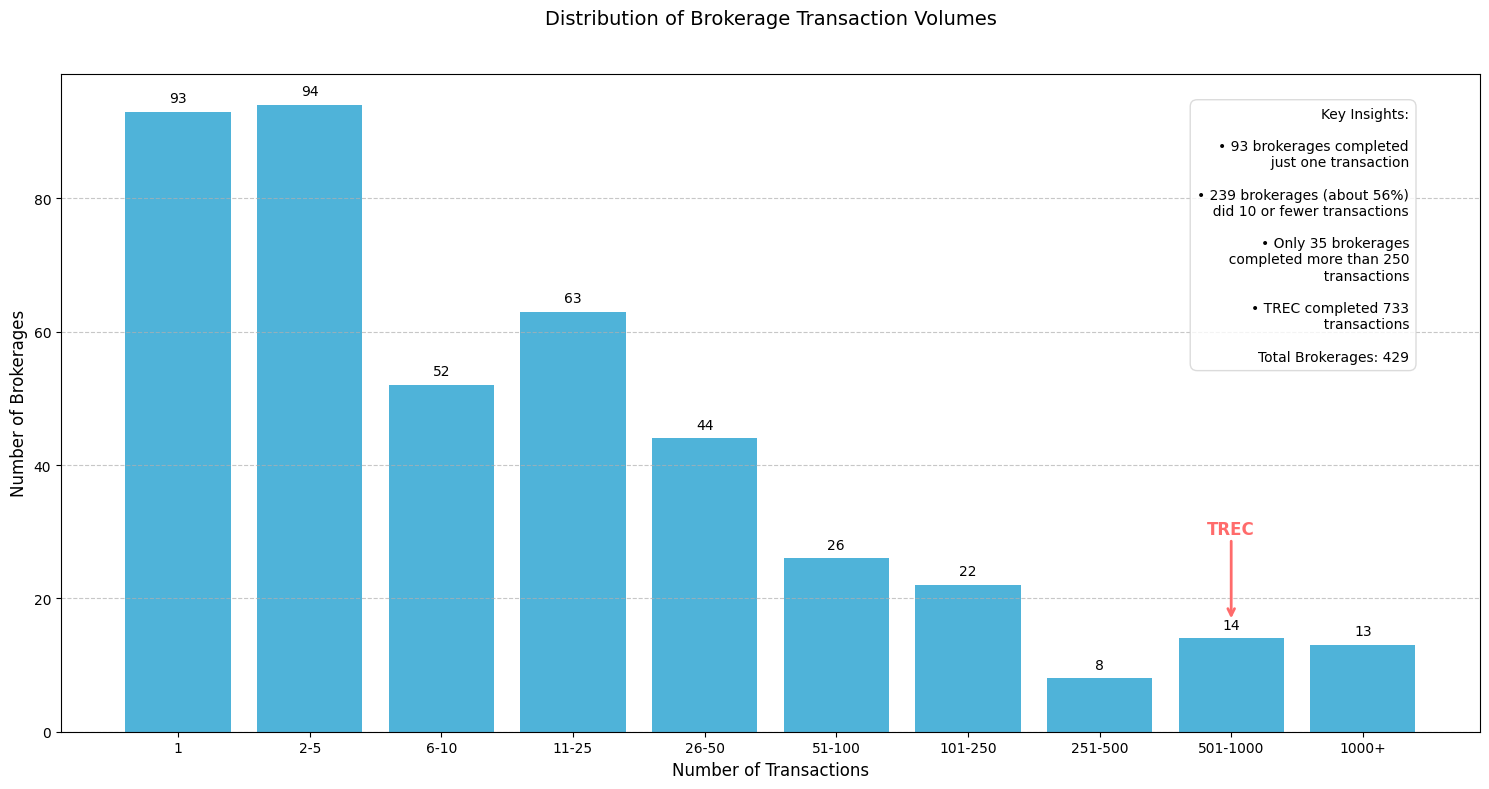


Analysis complete!


In [8]:
# ============================================
# SECTION: BROKERAGE TRANSACTION DISTRIBUTION ANALYSIS
# ============================================
# This section visualizes how transactions are distributed across brokerages
# We'll create a bar chart with key insights and highlight TREC with a downward arrow

if 'brokerage_analysis' not in locals():
    print("Error: brokerage_analysis not found. Please run the previous analysis block first.")
else:
    try:
        # ----------------------------------------
        # Prepare the data for visualization
        # ----------------------------------------
        # Get our office counts from the previous analysis
        office_counts = brokerage_analysis['office_counts']

        print("Analyzing brokerage transaction distribution...")
        print(f"Total brokerages to analyze: {len(office_counts):,}")

        # Define our transaction ranges
        bins = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000, float('inf')]
        labels = [
            '1',
            '2-5',
            '6-10',
            '11-25',
            '26-50',
            '51-100',
            '101-250',
            '251-500',
            '501-1000',
            '1000+'
        ]

        # Create DataFrame and categorize the data
        distribution_df = pd.DataFrame({'transactions': office_counts})
        distribution_df['range'] = pd.cut(
            distribution_df['transactions'],
            bins=bins,
            labels=labels,
            right=False
        )

        # Calculate our statistics
        range_counts = distribution_df['range'].value_counts().sort_index()
        range_percentages = (range_counts / len(office_counts) * 100).round(1)

        # ----------------------------------------
        # Identify TREC's position in the data
        # ----------------------------------------
        # Find TREC's transaction count and range
        trec_name = 'TREC The Real Estate Company'
        trec_transactions = office_counts.get(trec_name, 0)

        # Find which bin TREC falls into
        trec_range = pd.cut([trec_transactions], bins=bins, labels=labels)[0]
        trec_range_index = list(labels).index(trec_range)

        # ----------------------------------------
        # Create visualization with insights box
        # ----------------------------------------
        print("\nCreating visualization...")

        # Create figure and axis objects
        fig, ax = plt.subplots(figsize=(15, 8))

        # Add grid for better readability
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Create the bar plot (all bars in blue)
        bars = ax.bar(range(len(range_counts)), range_counts, color='#4FB3D9')

        # Set title and labels
        ax.set_title('Distribution of Brokerage Transaction Volumes\n',
                    fontsize=14, pad=20)
        ax.set_xlabel('Number of Transactions', fontsize=12)
        ax.set_ylabel('Number of Brokerages', fontsize=12)

        # Set x-axis labels
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}',
                   ha='center', va='bottom')

        # ----------------------------------------
        # Add TREC arrow and label
        # ----------------------------------------
        # Get the bar center coordinates for TREC's range
        trec_bar = bars[trec_range_index]

        # Calculate the center position of TREC's bar
        # get_x() gives us the left edge, we add half the width to get the center
        bar_center = trec_bar.get_x() + trec_bar.get_width()/2

        # Get the height of TREC's bar
        bar_height = trec_bar.get_height()

        # Define arrow positions
        # Start the arrow 15 units above the bar
        arrow_start_y = bar_height + 15
        # End the arrow 3 units above the bar
        arrow_end_y = bar_height + 3

        # Add the arrow and label
        ax.annotate('TREC',  # Text label
                   xy=(bar_center, arrow_end_y),  # Arrow tip position (near bar top)
                   xytext=(bar_center, arrow_start_y),  # Text position (above bar)
                   color='#FF6B6B',  # Red color
                   fontsize=12,  # Slightly larger font
                   fontweight='bold',  # Make it bold
                   ha='center',  # Center the text
                   va='bottom',  # Align text to bottom
                   arrowprops=dict(
                       arrowstyle='->',  # Arrow style
                       color='#FF6B6B',  # Red color
                       lw=2,  # Line width
                       shrinkA=0,  # Don't shrink arrow at the text end
                       shrinkB=0   # Don't shrink arrow at the bar end
                   ))

        # Calculate percentages for insights
        single_transaction_pct = range_percentages.iloc[0]
        small_volume_pct = range_percentages.iloc[:3].sum()
        high_volume_pct = range_percentages.iloc[-3:].sum()

        # Create insights text including TREC's information
        insights_text = "Key Insights:\n\n"
        insights_text += f"• {range_counts.iloc[0]} brokerages completed\n  just one transaction\n\n"
        insights_text += f"• {range_counts.iloc[:3].sum()} brokerages (about {small_volume_pct:.0f}%)\n  did 10 or fewer transactions\n\n"
        insights_text += f"• Only {range_counts.iloc[-3:].sum()} brokerages\n  completed more than 250\n  transactions\n\n"
        insights_text += f"• TREC completed {trec_transactions:,}\n  transactions\n\n"
        insights_text += f"Total Brokerages: {len(office_counts):,}"

        # Add text box to plot
        ax.text(0.95, 0.95, insights_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white',
                         alpha=0.8,
                         edgecolor='lightgray',
                         boxstyle='round,pad=0.5'))

        # Add spines (borders) to the plot
        for spine in ax.spines.values():
            spine.set_visible(True)

        # Set y-axis to start at 0
        ax.set_ylim(bottom=0)  # This ensures bars start at y=0

        # Adjust layout to prevent cutting off labels
        plt.tight_layout()

        # Display the plot
        plt.show()

        print("\nAnalysis complete!")

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please review the error and try again")

In [16]:
# ============================================
# SECTION: AGENT SUMMARY CREATION
# ============================================
# This section creates a summary of agent transactions
# Implements updated end calculation logic

# Verify we have our cleaned DataFrame
if 'cleaned_df' not in locals():
    print("Error: Please run the data cleaning block first.")
else:
    try:
        # ----------------------------------------
        # Initialize agent ends tracking
        # ----------------------------------------
        agent_ends = {}

        # Process each transaction
        for _, row in cleaned_df.iterrows():
            # Buyer Side Ends
            if pd.notna(row['buyer_agent']):
                if pd.notna(row['co_buyer_agent']):
                    # Both primary and co-buyer exist: 0.5 ends each
                    agent_ends[row['buyer_agent']] = agent_ends.get(row['buyer_agent'], 0) + 0.5
                    agent_ends[row['co_buyer_agent']] = agent_ends.get(row['co_buyer_agent'], 0) + 0.5
                else:
                    # Only primary buyer: 1.0 end
                    agent_ends[row['buyer_agent']] = agent_ends.get(row['buyer_agent'], 0) + 1.0

            # Listing Side Ends
            if pd.notna(row['list_agent']):
                if pd.notna(row['co_list_agent']):
                    # Both primary and co-lister exist: 0.5 ends each
                    agent_ends[row['list_agent']] = agent_ends.get(row['list_agent'], 0) + 0.5
                    agent_ends[row['co_list_agent']] = agent_ends.get(row['co_list_agent'], 0) + 0.5
                else:
                    # Only primary lister: 1.0 end
                    agent_ends[row['list_agent']] = agent_ends.get(row['list_agent'], 0) + 1.0

        # Convert to DataFrame
        agent_summary = pd.DataFrame.from_dict(
            agent_ends,
            orient='index',
            columns=['Total Ends']
        )

        # Reset index to make Agent a column
        agent_summary.reset_index(inplace=True)
        agent_summary.columns = ['Agent', 'Total Ends']

        # Sort by total ends in descending order
        agent_summary.sort_values('Total Ends', ascending=False, inplace=True)

        # Display summary statistics
        print("Agent Summary Statistics:")
        print(f"Total unique agents: {len(agent_summary):,}")
        print(f"Average total ends per agent: {agent_summary['Total Ends'].mean():.2f}")
        print(f"Median total ends per agent: {agent_summary['Total Ends'].median():.2f}")

        # Top 10 agents by transaction ends
        print("\nTop 10 Agents by Transaction Ends:")
        print(agent_summary.head(10))

        # Optional: Validate total ends
        total_expected_ends = len(cleaned_df) * 2
        total_calculated_ends = agent_summary['Total Ends'].sum()

        print(f"\nExpected Total Ends: {total_expected_ends:,}")
        print(f"Calculated Total Ends: {total_calculated_ends:,}")

        if abs(total_expected_ends - total_calculated_ends) > 0.1:
            print("Warning: Discrepancy in total ends calculation!")

    except Exception as e:
        print(f"An error occurred: {e}")

Agent Summary Statistics:
Total unique agents: 6,440
Average total ends per agent: 8.45
Median total ends per agent: 5.00

Top 10 Agents by Transaction Ends:
                   Agent  Total Ends
522         Justin Havre       327.5
143     Non Board Member       312.0
195         Jeff Jackson       206.0
42          Tanya Eklund       180.5
207         Jessica Chan       175.0
78          Dusko Sremac       125.5
1099         Matthew Mai       115.0
163          Len T. Wong       113.0
553    Michael Laprairie       112.0
554   Alexandria Stewart       106.5

Expected Total Ends: 54,438
Calculated Total Ends: 54,438.0


In [17]:
# ============================================
# SECTION: AGENT TRANSACTION VERIFICATION
# ============================================
# This section verifies our agent transaction calculations and provides statistics by:
# 1. Verifying total transaction ends
# 2. Analyzing the distribution of agent performance
# 3. Examining co-agent patterns

if 'cleaned_df' not in locals() or 'agent_summary' not in locals():
    print("Error: Please run both the data cleaning and agent analysis blocks first.")
else:
    try:
        print("Starting transaction verification...")

        # ----------------------------------------
        # Calculate Expected Ends
        # ----------------------------------------
        # Every transaction should have exactly 2.0 ends
        total_transactions = len(cleaned_df)
        expected_total_ends = total_transactions * 2  # Always 2 ends per transaction

        print(f"\nTransaction Counts:")
        print(f"Total transactions: {total_transactions:,}")
        print(f"Expected total ends: {expected_total_ends:,}")

        # ----------------------------------------
        # Calculate Actual Ends
        # ----------------------------------------
        # Sum all ends from our agent summary
        actual_total_ends = agent_summary['Total Ends'].sum()

        print(f"Actual total ends: {actual_total_ends:,}")

        # ----------------------------------------
        # Check for Discrepancy
        # ----------------------------------------
        difference = actual_total_ends - expected_total_ends

        print("\nVerification Results:")
        print(f"Difference (Actual - Expected): {difference:,.1f} ends")

        # Very small tolerance for floating-point arithmetic
        if abs(difference) > 0.1:
            print("\nDiscrepancy detected! Let's investigate further:")

            # Investigate potential data anomalies
            print("\nChecking for data anomalies:")

            # Check for any missing values in agent columns
            agent_columns = ['buyer_agent', 'co_buyer_agent', 'list_agent', 'co_list_agent']
            for col in agent_columns:
                empty_count = cleaned_df[col].isna().sum()
                print(f"Empty values in {col}: {empty_count:,}")

            # Examine most common agent values
            print("\nUnique values that might cause issues:")
            for col in agent_columns:
                unusual = cleaned_df[col].value_counts().head(3)
                print(f"\nMost common {col} values:")
                print(unusual)

        # ----------------------------------------
        # Agent Performance Statistics
        # ----------------------------------------
        print("\nDetailed Agent Performance Statistics:")

        # Calculate median ends per agent
        median_ends = agent_summary['Total Ends'].median()
        print(f"Median ends per agent: {median_ends:.1f}")

        # Additional distribution statistics
        q1 = agent_summary['Total Ends'].quantile(0.25)
        q3 = agent_summary['Total Ends'].quantile(0.75)

        print(f"25th percentile (Q1): {q1:.1f} ends")
        print(f"75th percentile (Q3): {q3:.1f} ends")

        # ----------------------------------------
        # Co-Agent Analysis
        # ----------------------------------------
        # Count transactions with co-agents
        transactions_with_co_buyers = cleaned_df['co_buyer_agent'].notna().sum()
        transactions_with_co_listers = cleaned_df['co_list_agent'].notna().sum()

        print(f"\nTransactions with co-agents:")
        print(f"With co-buyer agents: {transactions_with_co_buyers:,} ({transactions_with_co_buyers/total_transactions*100:.1f}%)")
        print(f"With co-listing agents: {transactions_with_co_listers:,} ({transactions_with_co_listers/total_transactions*100:.1f}%)")

        # ----------------------------------------
        # Top Agents Section
        # ----------------------------------------
        print("\nTop 10 Agents by Transaction Ends:")
        top_10_agents = agent_summary.head(10)
        print(top_10_agents)

        print("\nVerification complete!")

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please check the data and column names")

Starting transaction verification...

Transaction Counts:
Total transactions: 27,219
Expected total ends: 54,438
Actual total ends: 54,438.0

Verification Results:
Difference (Actual - Expected): 0.0 ends

Detailed Agent Performance Statistics:
Median ends per agent: 5.0
25th percentile (Q1): 2.0 ends
75th percentile (Q3): 11.0 ends

Transactions with co-agents:
With co-buyer agents: 2,626 (9.6%)
With co-listing agents: 6,954 (25.5%)

Top 10 Agents by Transaction Ends:
                   Agent  Total Ends
522         Justin Havre       327.5
143     Non Board Member       312.0
195         Jeff Jackson       206.0
42          Tanya Eklund       180.5
207         Jessica Chan       175.0
78          Dusko Sremac       125.5
1099         Matthew Mai       115.0
163          Len T. Wong       113.0
553    Michael Laprairie       112.0
554   Alexandria Stewart       106.5

Verification complete!


In [18]:
# ============================================
# SECTION: AGENT TRANSACTION ANALYSIS - LOW VOLUME
# ============================================
# This code analyzes agents with low transaction volumes and investigates missing ends
# We'll look at:
# 1. Agents with zero ends
# 2. Agents with exactly one end
# 3. The distribution of low-volume agents

if 'cleaned_df' not in locals() or 'agent_summary' not in locals():
    print("Error: Please run both the data cleaning and agent analysis blocks first.")
else:
    try:
        print("Starting low volume agent analysis...")

        # ----------------------------------------
        # Analyze Low Volume Agents
        # ----------------------------------------
        # Count agents with specific end counts
        zero_ends = len(agent_summary[agent_summary['Total Ends'] == 0])
        one_end = len(agent_summary[agent_summary['Total Ends'] == 1])
        half_end = len(agent_summary[agent_summary['Total Ends'] == 0.5])

        print("\nLow Volume Agent Analysis:")
        print(f"Agents with zero ends: {zero_ends:,}")
        print(f"Agents with exactly one end: {one_end:,}")
        print(f"Agents with exactly 0.5 ends: {half_end:,}")

        # Show percentage of total agents
        total_agents = len(agent_summary)
        print(f"\nAs percentage of total agents ({total_agents:,}):")
        print(f"Zero ends: {zero_ends/total_agents*100:.1f}%")
        print(f"One end: {one_end/total_agents*100:.1f}%")
        print(f"Half end: {half_end/total_agents*100:.1f}%")

        # ----------------------------------------
        # Investigate Missing Ends
        # ----------------------------------------
        print("\nInvestigating Missing Ends...")

        # Create a list to store problematic transactions
        problem_rows = []

        # Examine each transaction
        for idx, row in cleaned_df.iterrows():
            # Initialize end counts for this transaction
            buyer_ends = 0
            list_ends = 0

            # Count buyer side ends
            if pd.notna(row['buyer_agent']):
                if pd.notna(row['co_buyer_agent']):
                    buyer_ends = 1.0  # 0.5 each for agent and co-agent
                else:
                    buyer_ends = 1.0  # Full end for single agent

            # Count listing side ends
            if pd.notna(row['list_agent']):
                if pd.notna(row['co_list_agent']):
                    list_ends = 1.0  # 0.5 each for agent and co-agent
                else:
                    list_ends = 1.0  # Full end for single agent

            total_ends = buyer_ends + list_ends

            # If total ends isn't 2, this is a problem transaction
            if total_ends != 2:
                problem_rows.append({
                    'mls': row['mls'],
                    'total_ends': total_ends,
                    'buyer_ends': buyer_ends,
                    'list_ends': list_ends,
                    'buyer_agent': row['buyer_agent'],
                    'co_buyer_agent': row['co_buyer_agent'],
                    'list_agent': row['list_agent'],
                    'co_list_agent': row['co_list_agent']
                })

        # Convert problem rows to DataFrame
        if problem_rows:
            problem_df = pd.DataFrame(problem_rows)

            print(f"\nFound {len(problem_df):,} transactions with missing ends!")
            print("\nSample of problematic transactions:")

            # Set display options for better visibility
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_rows', 10)

            # Show the first few problem transactions
            print("\nFirst few problematic transactions:")
            print(problem_df.head().to_string())

            # Save all problem transactions to CSV
            problem_df.to_csv('missing_ends_transactions.csv', index=False)
            print("\nFull list of problematic transactions saved to 'missing_ends_transactions.csv'")

            # Show summary of problems
            print("\nProblem Summary:")
            print(f"Total problem transactions: {len(problem_df):,}")
            print("\nBreakdown of total ends in problem transactions:")
            print(problem_df['total_ends'].value_counts().sort_index())
        else:
            print("No transactions found with missing ends.")
            print("The discrepancy might be due to rounding or data handling.")

        print("\nAnalysis complete!")

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please check the error message and data structure")

Starting low volume agent analysis...

Low Volume Agent Analysis:
Agents with zero ends: 0
Agents with exactly one end: 1,000
Agents with exactly 0.5 ends: 244

As percentage of total agents (6,440):
Zero ends: 0.0%
One end: 15.5%
Half end: 3.8%

Investigating Missing Ends...
No transactions found with missing ends.
The discrepancy might be due to rounding or data handling.

Analysis complete!


In [35]:
def search_agent_details(name_query):
    """
    Search for an agent's transaction details, including:
    - Total Transaction Ends
    - Total Sales Value

    Parameters:
    -----------
    name_query : str
        Partial or full name of the agent to search for

    Returns:
    --------
    Prints agent details or informs if no match is found
    """
    # Convert search query to lowercase for case-insensitive matching
    name_query = name_query.lower()

    # Create a function to find agent's transactions
    def find_agent_transactions(df, name_query):
        """
        Find all transactions where the agent is involved
        """
        agent_transactions = df[
            (df['buyer_agent'].str.lower().str.contains(name_query)) |
            (df['co_buyer_agent'].str.lower().str.contains(name_query)) |
            (df['list_agent'].str.lower().str.contains(name_query)) |
            (df['co_list_agent'].str.lower().str.contains(name_query))
        ]
        return agent_transactions

    # Find matching transactions
    matching_transactions = find_agent_transactions(cleaned_df, name_query)

    # Check if any transactions were found
    if matching_transactions.empty:
        print(f"No transactions found for '{name_query}'.")
        return

    # Find matching agents in agent summary
    matching_agents = agent_summary[
        agent_summary['Agent'].str.lower().str.contains(name_query)
    ]

    # Display results
    print(f"\nSearch Results for '{name_query}':")
    print("-" * 70)

    for idx, agent_row in matching_agents.iterrows():
        agent_name = agent_row['Agent']

        # Filter transactions for this specific agent
        agent_buyer_transactions = matching_transactions[
            (matching_transactions['buyer_agent'] == agent_name) |
            (matching_transactions['co_buyer_agent'] == agent_name)
        ]

        agent_list_transactions = matching_transactions[
            (matching_transactions['list_agent'] == agent_name) |
            (matching_transactions['co_list_agent'] == agent_name)
        ]

        # Ensure close_price is numeric
        # Remove '$' and ',' if present, then convert to float
        def clean_price(series):
            return pd.to_numeric(series.astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')

        # Calculate total sales values
        buyer_sales_total = clean_price(agent_buyer_transactions['close_price']).sum()
        list_sales_total = clean_price(agent_list_transactions['close_price']).sum()
        total_sales = buyer_sales_total + list_sales_total

        # Print detailed information
        print("Agent Name: {}".format(agent_name))
        print("Total Transaction Ends: {:.1f}".format(agent_row['Total Ends']))
        print("Total Sales Value: ${:,.2f}".format(total_sales))
        print("  - Buyer Side Sales: ${:,.2f}".format(buyer_sales_total))
        print("  - Listing Side Sales: ${:,.2f}".format(list_sales_total))
        print("Total Transactions: {}".format(len(agent_buyer_transactions) + len(agent_list_transactions)))
        print("-" * 70)

    # Return the matching transactions for further analysis if needed
    return matching_transactions

# Example usage instructions
print("\n--- Advanced Agent Search Function Ready ---")
print("To search for an agent's details, use: search_agent_details('justin')")
print("Examples:")
print("  search_agent_details('justin')  # Finds all agents with 'justin' in their name")
print("  search_agent_details('havre')   # Finds all agents with 'havre' in their name")


--- Advanced Agent Search Function Ready ---
To search for an agent's details, use: search_agent_details('justin')
Examples:
  search_agent_details('justin')  # Finds all agents with 'justin' in their name
  search_agent_details('havre')   # Finds all agents with 'havre' in their name


In [39]:
# Search for all agents with 'justin' in their name
search_agent_details('kevin chau')




Search Results for 'kevin chau':
----------------------------------------------------------------------
Agent Name: Kevin Chau
Total Transaction Ends: 27.0
Total Sales Value: $17,346,005.00
  - Buyer Side Sales: $8,172,105.00
  - Listing Side Sales: $9,173,900.00
Total Transactions: 27
----------------------------------------------------------------------


,mls,city,buyer_office,list_office,current_price,close_price,co_buyer_agent,buyer_agent,list_agent,co_list_agent
866,A2099670,Calgary,The Real Estate Company,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$785,000.00","$785,000.00",NaN,Fei Ye,Kevin Chau,NaN
1860,A2099703,Calgary,Charles,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$625,000.00","$625,000.00",NaN,Colum Cavilla,Kevin Chau,NaN
2090,A2103332,Calgary,RE/MAX Real Estate (Mountain View),Real Broker,"$595,000.00","$595,000.00",NaN,Kevin Chau,Leanne McNabb,Tyler McNabb
2207,A2106756,Calgary,RE/MAX Real Estate (Mountain View),eXp Realty,"$577,605.00","$577,605.00",NaN,Kevin Chau,Adnan Ali Assaf,NaN
2267,A2101969,Calgary,RE/MAX Real Estate (Mountain View),RE/MAX First,"$570,000.00","$570,000.00",NaN,Kevin Chau,Ariel Buenaventura,NaN
2548,A2099706,Calgary,URBAN-REALTY.ca,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$532,000.00","$532,000.00",NaN,Travis Forster,Kevin Chau,NaN
2750,A2101815,Calgary,RE/MAX Real Estate (Central),RE/MAX Real Estate (Mountain View),"$500,000.00","$500,000.00",NaN,Ginger Andrews,Kevin Chau,NaN
3651,A2106639,Calgary,RE/MAX Landan Real Estate,RE/MAX Real Estate (Mountain View),"$362,000.00","$362,000.00",NaN,Greg Wiseman,Kevin Chau,NaN
3684,A2089438,Calgary,RE/MAX Real Estate (Mountain View),CENTURY 21 BAMBER REALTY LTD.,"$360,000.00","$360,000.00",NaN,Kevin Chau,Mike Dreger,NaN
4737,A2104546,Calgary,RE/MAX Real Estate (Mountain View),MaxWell Capital Realty,"$228,000.00","$228,000.00",NaN,Kevin Chau,Brett Mote,NaN


In [42]:
def search_agent_details(name_query):
    """
    Search for an agent's transaction details, including:
    - Total Transaction Ends
    - Total Sales Value
    - Total Commissions

    Parameters:
    -----------
    name_query : str
        Partial or full name of the agent to search for

    Returns:
    --------
    Prints agent details or informs if no match is found
    """
    # Convert search query to lowercase for case-insensitive matching
    name_query = name_query.lower()

    # Create a function to find agent's transactions
    def find_agent_transactions(df, name_query):
        """
        Find all transactions where the agent is involved
        """
        agent_transactions = df[
            (df['buyer_agent'].str.lower().str.contains(name_query)) |
            (df['co_buyer_agent'].str.lower().str.contains(name_query)) |
            (df['list_agent'].str.lower().str.contains(name_query)) |
            (df['co_list_agent'].str.lower().str.contains(name_query))
        ]
        return agent_transactions

    # Commission calculation function with robust numeric conversion
    def calculate_single_transaction_commission(close_price):
        """
        Calculate commission for a single transaction based on tiered structure.

        3.5% on first $100,000
        1.5% on remaining amount
        """
        # Robust numeric conversion
        try:
            # Remove '$' and ',' if present, then convert to float
            if isinstance(close_price, str):
                close_price = float(close_price.replace('$', '').replace(',', ''))

            # Ensure we have a numeric value
            close_price = float(close_price)

            if close_price <= 100000:
                return close_price * 0.035
            else:
                first_tier = 100000 * 0.035
                remaining_tier = (close_price - 100000) * 0.015
                return first_tier + remaining_tier
        except (ValueError, TypeError):
            print(f"Warning: Could not convert {close_price} to a numeric value")
            return 0.0

    # Find matching transactions
    matching_transactions = find_agent_transactions(cleaned_df, name_query)

    # Check if any transactions were found
    if matching_transactions.empty:
        print(f"No transactions found for '{name_query}'.")
        return

    # Find matching agents in agent summary
    matching_agents = agent_summary[
        agent_summary['Agent'].str.lower().str.contains(name_query)
    ]

    # Display results
    print(f"\nSearch Results for '{name_query}':")
    print("-" * 70)

    for idx, agent_row in matching_agents.iterrows():
        agent_name = agent_row['Agent']

        # Filter transactions for this specific agent
        agent_buyer_transactions = matching_transactions[
            (matching_transactions['buyer_agent'] == agent_name) |
            (matching_transactions['co_buyer_agent'] == agent_name)
        ]

        agent_list_transactions = matching_transactions[
            (matching_transactions['list_agent'] == agent_name) |
            (matching_transactions['co_list_agent'] == agent_name)
        ]

        # Ensure close_price is numeric with robust conversion
        def clean_price(series):
            return series.apply(lambda x: float(str(x).replace('$', '').replace(',', '')) if pd.notna(x) else 0)

        # Calculate total sales values
        buyer_sales_total = clean_price(agent_buyer_transactions['close_price']).sum()
        list_sales_total = clean_price(agent_list_transactions['close_price']).sum()
        total_sales = buyer_sales_total + list_sales_total

        # Calculate commissions
        buyer_commission = 0
        list_commission = 0

        # Buyer side commission calculation
        if pd.notna(agent_buyer_transactions['buyer_agent']).any():
            if len(agent_buyer_transactions[agent_buyer_transactions['co_buyer_agent'].notna()]) > 0:
                # Split commission if co-buyer present
                buyer_commission = sum(
                    calculate_single_transaction_commission(row['close_price']) / 2
                    for _, row in agent_buyer_transactions[
                        (agent_buyer_transactions['buyer_agent'] == agent_name) |
                        (agent_buyer_transactions['co_buyer_agent'] == agent_name)
                    ].iterrows()
                )
            else:
                # Full commission for sole buyer agent
                buyer_commission = sum(
                    calculate_single_transaction_commission(row['close_price'])
                    for _, row in agent_buyer_transactions[
                        agent_buyer_transactions['buyer_agent'] == agent_name
                    ].iterrows()
                )

        # Listing side commission calculation
        if pd.notna(agent_list_transactions['list_agent']).any():
            if len(agent_list_transactions[agent_list_transactions['co_list_agent'].notna()]) > 0:
                # Split commission if co-lister present
                list_commission = sum(
                    calculate_single_transaction_commission(row['close_price']) / 2
                    for _, row in agent_list_transactions[
                        (agent_list_transactions['list_agent'] == agent_name) |
                        (agent_list_transactions['co_list_agent'] == agent_name)
                    ].iterrows()
                )
            else:
                # Full commission for sole listing agent
                list_commission = sum(
                    calculate_single_transaction_commission(row['close_price'])
                    for _, row in agent_list_transactions[
                        agent_list_transactions['list_agent'] == agent_name
                    ].iterrows()
                )

        total_commission = buyer_commission + list_commission

        # Print detailed information
        print("Agent Name: {}".format(agent_name))
        print("Total Transaction Ends: {:.1f}".format(agent_row['Total Ends']))
        print("Total Sales Value: ${:,.2f}".format(total_sales))
        print("  - Buyer Side Sales: ${:,.2f}".format(buyer_sales_total))
        print("  - Listing Side Sales: ${:,.2f}".format(list_sales_total))
        print("Total Commission: ${:,.2f}".format(total_commission))
        print("  - Buyer Side Commission: ${:,.2f}".format(buyer_commission))
        print("  - Listing Side Commission: ${:,.2f}".format(list_commission))
        print("Total Transactions: {}".format(len(agent_buyer_transactions) + len(agent_list_transactions)))
        print("-" * 70)

    # Return the matching transactions for further analysis if needed
    return matching_transactions

In [45]:
search_agent_details('kevin chau')


Search Results for 'kevin chau':
----------------------------------------------------------------------
Agent Name: Kevin Chau
Total Transaction Ends: 27.0
Total Sales Value: $17,346,005.00
  - Buyer Side Sales: $8,172,105.00
  - Listing Side Sales: $9,173,900.00
Total Commission: $314,190.08
  - Buyer Side Commission: $148,581.58
  - Listing Side Commission: $165,608.50
Total Transactions: 27
----------------------------------------------------------------------


,mls,city,buyer_office,list_office,current_price,close_price,co_buyer_agent,buyer_agent,list_agent,co_list_agent
866,A2099670,Calgary,The Real Estate Company,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$785,000.00","$785,000.00",NaN,Fei Ye,Kevin Chau,NaN
1860,A2099703,Calgary,Charles,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$625,000.00","$625,000.00",NaN,Colum Cavilla,Kevin Chau,NaN
2090,A2103332,Calgary,RE/MAX Real Estate (Mountain View),Real Broker,"$595,000.00","$595,000.00",NaN,Kevin Chau,Leanne McNabb,Tyler McNabb
2207,A2106756,Calgary,RE/MAX Real Estate (Mountain View),eXp Realty,"$577,605.00","$577,605.00",NaN,Kevin Chau,Adnan Ali Assaf,NaN
2267,A2101969,Calgary,RE/MAX Real Estate (Mountain View),RE/MAX First,"$570,000.00","$570,000.00",NaN,Kevin Chau,Ariel Buenaventura,NaN
2548,A2099706,Calgary,URBAN-REALTY.ca,RE/MAX REAL ESTATE (MOUNTAIN VIEW),"$532,000.00","$532,000.00",NaN,Travis Forster,Kevin Chau,NaN
2750,A2101815,Calgary,RE/MAX Real Estate (Central),RE/MAX Real Estate (Mountain View),"$500,000.00","$500,000.00",NaN,Ginger Andrews,Kevin Chau,NaN
3651,A2106639,Calgary,RE/MAX Landan Real Estate,RE/MAX Real Estate (Mountain View),"$362,000.00","$362,000.00",NaN,Greg Wiseman,Kevin Chau,NaN
3684,A2089438,Calgary,RE/MAX Real Estate (Mountain View),CENTURY 21 BAMBER REALTY LTD.,"$360,000.00","$360,000.00",NaN,Kevin Chau,Mike Dreger,NaN
4737,A2104546,Calgary,RE/MAX Real Estate (Mountain View),MaxWell Capital Realty,"$228,000.00","$228,000.00",NaN,Kevin Chau,Brett Mote,NaN
